In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [13]:
import foregrounds as fg
from scipy.optimize import curve_fit
import spectra as spec
import glob

In [4]:
from __future__ import unicode_literals

figsize(8, 6)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [5]:
freqs = np.logspace(8, 13, 2000)
nu = freqs*1.e-9

In [6]:
# aperture is from 60' to 90' because of the size of our GBT maps. 
# radius is 45'
# smoothed by 40'

In [7]:
spectrum = spec.AperturePhotometry(inside=60., outside=90., radius=45.)

In [8]:
spectrum.get_cgps_flux(sbeam=40.)

(18.379105, 2.6314612127222694)

In [9]:
# 408 MHz
cgpsfreq = [408.e6]
cgpsflux = [18.38]
cgpserr = [2.6]

In [10]:
spectrum.get_21cm_flux(sbeam=40.)

Sigma is 7.404216 arcmin (0.002154 rad) 
-> fwhm is 17.435596 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


(20.612205394156192, 2.1299956997987874)

In [11]:
# 1420 MHz
stockertfreq = [1.42e9]
stockertflux = [20.6]
stockerterr = [2.1]

In [12]:
# GBT
gbtA = 17.24
gbtB = 17.60
gbtC = 18.88
gbtAerr = 2.
gbtBerr = 2.
gbtCerr = 2.
gbtfreqs = [4.575e9, 5.625e9, 6.125e9]
gbtflux = [gbtA, gbtB, gbtC]
gbterrs = [gbtAerr, gbtBerr, gbtCerr]

In [21]:
pfiles = ['../externaldata/planck_smoothed_28_40.fits',
 '../externaldata/planck_smoothed_44_40.fits',
 '../externaldata/planck_smoothed_70_40.fits',
 '../externaldata/planck_smoothed_143_40.fits',
 '../externaldata/planck_smoothed_217_40.fits',
 '../externaldata/planck_smoothed_353_40.fits',
 '../externaldata/planck_smoothed_545_40.fits',
 '../externaldata/planck_smoothed_857_40.fits']

In [22]:
# Planck
planckfreqs = spectrum.planckfreqs
planckflux, planckerrs = spectrum.run_experiment(pfiles)
planckerrs = np.sqrt( (0.03 * np.array(planckflux))**2 + np.array(planckerrs)**2)

In [29]:
irisfiles = ['../externaldata/iris_smoothed_25000_40.fits', \
            '../externaldata/iris_smoothed_12000_40.fits', \
            '../externaldata/iris_smoothed_5000_40.fits', \
            '../externaldata/iris_smoothed_3000_40.fits']

In [30]:
# IRIS
irisfreqs = spectrum.irisfreqs
irisflux, iriserrs = spectrum.run_experiment(irisfiles)
iriserrs = np.array(iriserrs) * 5.

In [37]:
dirbefiles = ['../externaldata/dirbe_smoothed_1250_40.fits', \
             '../externaldata/dirbe_smoothed_2142_40.fits', \
             '../externaldata/dirbe_smoothed_3000_40.fits']

In [46]:
# DIRBE
dirbefreqs = [1250.e9, 2142e9, 3000e9]
dirbeflux, dirbeerrs = spectrum.run_experiment(dirbefiles)
dirbeerrs = np.array(dirbeerrs) * 3.

In [47]:
bigfreqs = np.concatenate([cgpsfreq, stockertfreq, gbtfreqs, planckfreqs, irisfreqs, dirbefreqs])

In [48]:
bigflux = np.concatenate([cgpsflux, stockertflux, gbtflux, planckflux, irisflux, dirbeflux])

In [49]:
bigerrs = np.concatenate([cgpserr, stockerterr, gbterrs, planckerrs, iriserrs, dirbeerrs])

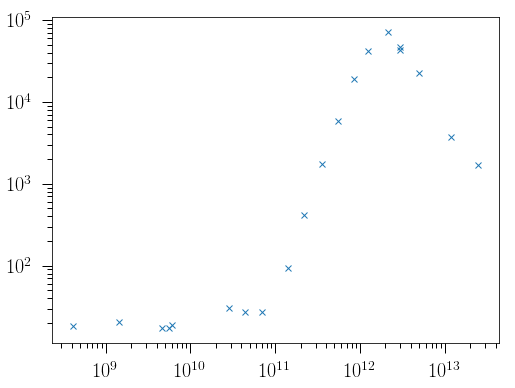

In [50]:
loglog(bigfreqs, bigflux, 'x')

In [51]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [52]:
def signal2(freqs, EM1, EM2, abeam, Ad, Bd, Td, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=Td) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [53]:
beam = pi*(1.*pi/180.)**2
beam2 = pi*((1./60.)*pi/180.)**2

In [54]:
mask = bigfreqs < 3e12

In [55]:
pn = np.array([100., 1.e-3, 20.e9, 1.e-4, 2., 20., 30.e-6])
x = curve_fit(signal, bigfreqs[mask], bigflux[mask], p0=pn, sigma=bigerrs[mask], absolute_sigma=True)
pfit1 = x[0]

In [56]:
pn2 = np.array([100., 1.e9, 5.e-10, 1.e-4, 2., 20., 30e-6])
y = curve_fit(signal2, bigfreqs[mask], bigflux[mask], p0=pn2, sigma=bigerrs[mask], absolute_sigma=True)
pfit2 = y[0]

In [57]:
pfit1

array([  1.99208476e+02,   7.76209720e-04,   3.29007355e+10,
         6.79975265e-04,   1.47799123e+00,   2.34765108e+01,
         2.12887465e-05])

In [58]:
pfit2

array([  1.79763387e+02,   8.87702296e+08,   3.62206745e-10,
         6.90828787e-04,   1.21910964e+00,   2.70930900e+01,
        -1.40630071e-04])

In [59]:
np.sqrt(4.60737512e-10 / pi) * 180. / pi * 60. * 60. # arcseconds

2.4979111306502078

In [60]:
figsize(16, 10)

(10, 100000.0)

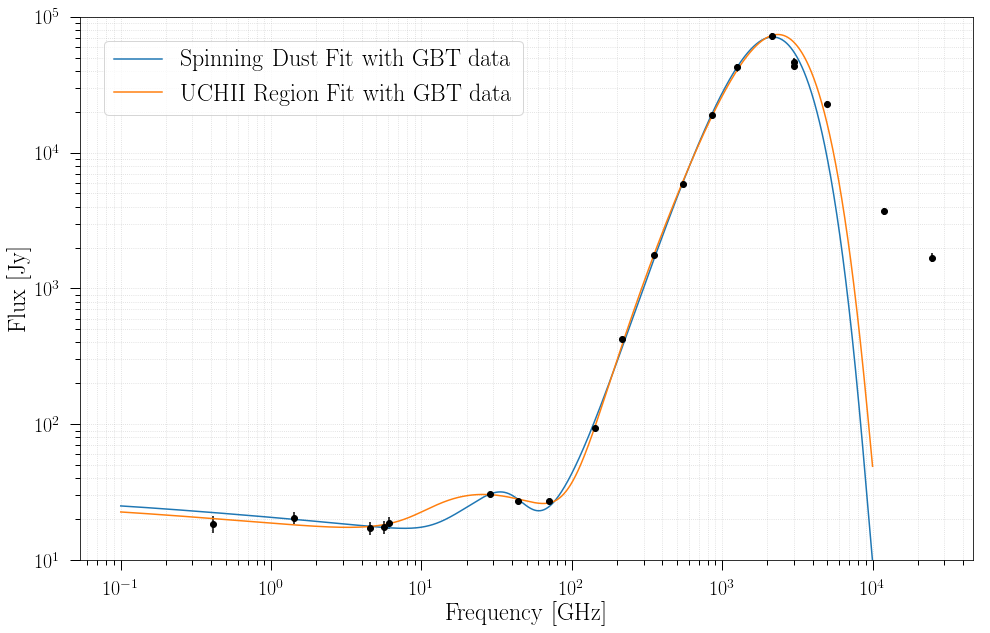

In [61]:
plot(nu, signal(freqs, *pfit1), label='$\mathrm{Spinning\ Dust\ Fit\ with\ GBT\ data}$')
plot(nu, signal2(freqs, *pfit2), label='$\mathrm{UCHII\ Region\ Fit\ with\ GBT\ data}$')
errorbar(bigfreqs*1.e-9, bigflux, yerr=bigerrs, fmt='ko')
#errorbar(bigfreqs*1.e-9, bigflux, yerr=bigerrs, fmt='ko',\
#         label='$\mathrm{Haslam,\ Reich,\ WMAP,}$\n$\mathrm{Planck,\ and\ DIRBE\ data}$')
#errorbar(nfreqs*1e-9, newdata, yerr=nerrs, fmt='rx', markersize=10)

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
legend(loc=2, ncol=1)
grid(ls='dotted', alpha=0.5)
grid(which='minor', ls='dotted', alpha=0.5)
ylim(10, 1e5)
#savefig('../notebooks/fullspectrum_with_gbt.pdf', format='pdf')

In [63]:
ame0a = fg.ame(freqs, pfit1[1], pfit1[2]) * beam
ff2a = fg.freefreep(freqs, EM=pfit2[1]) * pfit2[2]

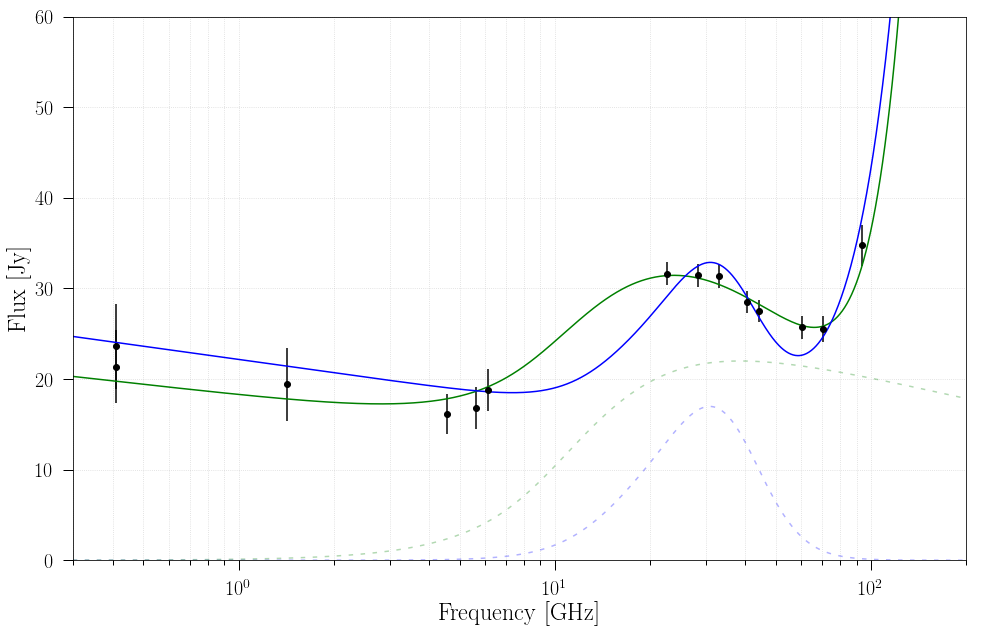

In [66]:
plot(nu, signal2(freqs, *pfit2), 'green')
plot(nu, signal(freqs, *pfit1), 'blue')
errorbar(bigfreqs*1.e-9, bigflux, yerr=bigerrs, fmt='ko')

alpha = 0.3
plot(nu, ame0a, 'blue', alpha=alpha, ls='dashed', dashes=(3,5))
plot(nu, ff2a, 'green', alpha=alpha, ls='dashed', dashes=(3,5))

xscale('log')
ylim(0, 60)
xlim(0.3, 200)
xlabel('$\mathrm{Frequency\ [GHz]}$')
ylabel('$\mathrm{Flux\ [Jy]}$')
#legend(loc=2, ncol=2)
grid(ls='dotted', alpha=0.5)
grid(which='minor', ls='dotted', alpha=0.5)

#text(2, 5, '$\mathrm{UCHII\ free-free}$\n $\mathrm{component}$', fontsize=24, color='green', alpha=0.7);
#savefig('../notebooks/freefreefit.pdf', format='pdf')